In [1]:
#     load packages
import os 
import zipfile
import urllib
import pandas as pd
import numpy as np
import string
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import time 
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
import pickle

In [2]:
#    load the data
#    The data is received from http://jmcauley.ucsd.edu/data/amazon/ 
#    You will need to contact Julian McAuley of UCSD to obtain it
#
#    From this dataset:
#    I have used a preprocessing script to extract a small sample, convert to dataframe and save in pickle format. 
#
#    That dataframe will be read from the pickle file into this notebook.

pname="amazon_reviews_limited.pickle"
#fname = os.path.join(os.getcwd(),pname)
df = pd.read_pickle(pname)

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,textvec,labelvec
0,A00000262KYZUE4J55XGL,B003UYU16G,Steven N Elich,"[0, 0]",1353456000,It is and does exactly what the description sa...,5.0,"11 21, 2012",Does what it's supposed to do,Does what it's supposed to do It is and does e...,0
1,A000008615DZQRRI946FO,B005FYPK9C,mj waldon,"[0, 0]",1357603200,I was sketchy at first about these but once yo...,5.0,"01 8, 2013",great buy,great buy I was sketchy at first about these b...,0
2,A00000922W28P2OCH6JSE,B000VEBG9Y,Gabriel Merrill,"[0, 0]",1395619200,Very mobile product. Efficient. Easy to use; h...,3.0,"03 24, 2014",Great product but needs a varmint guard.,Great product but needs a varmint guard. Very ...,0
3,A00000922W28P2OCH6JSE,B001EJMS6K,Gabriel Merrill,"[0, 0]",1395619200,Easy to use a mobile. If you're taller than 4f...,4.0,"03 24, 2014",Great inexpensive product. Mounts easily and t...,Great inexpensive product. Mounts easily and t...,0
4,A00000922W28P2OCH6JSE,B003XJCNVO,Gabriel Merrill,"[0, 0]",1395619200,Love this feeder. Heavy duty & capacity. Best ...,4.0,"03 24, 2014",Great feeder. Would recommend for use for thos...,Great feeder. Would recommend for use for thos...,0


In [3]:
# understand some basic facts about data

noreviews = len(df)
users=len(df["reviewerID"].unique())
prods=len(df["asin"].unique())
df["datevec"]=pd.to_datetime(df["reviewTime"])
syear = min(df["datevec"].apply(lambda x: x.year))
smth = min(df["datevec"].apply(lambda x: x.month))
eyear = max(df["datevec"].apply(lambda x: x.year))
emth = max(df["datevec"].apply(lambda x: x.month))

print "No of Product Reviews, Unique Users, Unique Products, Year, Month To Year, Month"
print [noreviews, users, prods, syear, smth, eyear, emth]

No of Product Reviews, Unique Users, Unique Products, Year, Month To Year, Month
[30000, 11306, 26935, 2012, 1, 2014, 12]


In [4]:
#    We are interested in predicting a negative review purely based on review headline and review text
#    We consider any review that is a 2 star or 1 star as negative and label it as 1 
#    Remaining all reviews are labeled as 0

df["labelvec"] = np.vectorize(lambda x: 1 if(x<3.0) else 0)(df["overall"])
df["textvec"] = df["summary"] + " " + df["reviewText"]
 

#    check proper coding of label from class
print "1. check counts and percentages \n"
print pd.crosstab(df["labelvec"],df["overall"],margins=True)
print "\n"

#    check balance between positive and negative cases (1 vs 0)
#    check the percentage of positive cases 
print pd.crosstab(df["labelvec"],df["overall"],margins=True).apply(lambda x: (x/len(df))*100, axis=1)
print "\n"

1. check counts and percentages 

overall    1.0   2.0   3.0   4.0    5.0    All
labelvec                                      
0            0     0  2556  5345  18508  26409
1         2322  1269     0     0      0   3591
All       2322  1269  2556  5345  18508  30000


overall    1.0   2.0   3.0        4.0        5.0     All
labelvec                                                
0         0.00  0.00  8.52  17.816667  61.693333   88.03
1         7.74  4.23  0.00   0.000000   0.000000   11.97
All       7.74  4.23  8.52  17.816667  61.693333  100.00




In [10]:
df.columns

Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary', u'textvec',
       u'labelvec', u'datevec'],
      dtype='object')

In [5]:
#    preprocess strings to normalize and improve model performance
#    convert to lowercase, remove punctuations, numbers and extra spaces, tabs etc.
#    Stopwords removal at the time of Doc x Term matrix creation
#    We save Doc x Term Matrix in pickle format for faster iterations when the data does not change 
#    Allows to try out/iterate different models quickly

if not os.path.exists("Amazondocterm.pickle"):
	t1 = time.time()
	message = np.vectorize(lambda x: x.lower())(df["textvec"])
	message = np.vectorize(lambda x: re.sub("["+string.punctuation+"]"," ",x))(message)
	message = np.vectorize(lambda x: re.sub("[0123456789]"," ",x))(message)
	message = np.vectorize(lambda x: " ".join(x.split()))(message)
	t2 = time.time()

	print "\n Text pre-processing time in seconds: " + str(t2-t1)

In [6]:
#    we will create a document x term matrix which will be passed to learner
#    The counts will be using TF-IDF to differentiate unique terms and add higher weight to them
#    you may need to run nltk.download()
#    consider only the top 5000 words as features

word_features = 5000

if not os.path.exists("Amazondocterm.pickle"):
	t1 = time.time()
	tfidfconvert = TfidfVectorizer(tokenizer=nltk.word_tokenize,stop_words="english",max_features=word_features)
	termdoc = tfidfconvert.fit_transform(message)
	t2=time.time()

	print "\n Doc x Term Matrix pre-processing time in seconds: " + str(t2-t1)
	with open("Amazondocterm.pickle","wb") as f:
		pickle.dump(termdoc,f)
else:
	with open("Amazondocterm.pickle","rb") as f:
		termdoc = pickle.load(f)

print "2. Document x Term Matrix size : "+ str(termdoc.shape[0])+" rows by "+ str(termdoc.shape[1])+" columns \n"

2. Document x Term Matrix size : 30000 rows by 5000 columns 



In [7]:
nrow = termdoc.shape[0]
ncol = termdoc.shape[1]

#    divide in training, cross validation and a test set 
train_set = np.random.choice(nrow,int(round(0.8*nrow)),replace=False)
remn_data = np.delete(range(nrow),train_set)
cv_set = np.random.choice(remn_data,int(round(0.9*remn_data.shape[0])),replace=False)
test_set = np.setdiff1d(remn_data,cv_set)

print "4. Training Set Size : " + str(len(train_set))
print "5. Cross-Validation Set Size : " + str(len(cv_set))
print "6. Test Set Size : " + str(len(test_set))

# actual training and test data
matrix_train = termdoc[train_set] 
matrix_cv = termdoc[cv_set] 
matrix_test = termdoc[test_set] 
target_train = np.transpose([df["labelvec"][train_set]])
target_cv = np.transpose([df["labelvec"][cv_set]])
target_test = np.transpose([df["labelvec"][test_set]])


4. Training Set Size : 24000
5. Cross-Validation Set Size : 5400
6. Test Set Size : 600


In [ ]:
#### ---- Try out different models from Scikit-Learn

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as score

In [19]:
#Gradient Boosted Classifier
gb = GradientBoostingClassifier(n_estimators=500, max_depth=11)

start = time.time()
gb_model = gb.fit(matrix_train, np.ravel(target_train))
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(matrix_test)
end = time.time()
pred_time = (end - start)


In [20]:
print " Gradient Boost Model Fit Summary : "
precision, recall, fscore, train_support = score(target_test, y_pred, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((pd.DataFrame(target_test) == pd.DataFrame(y_pred)).sum()/len(y_pred), 3)))

 Gradient Boost Model Fit Summary : 
Fit time: 298.576 / Predict time: 0.033 ---- Precision: 0.9 / Recall: 0.554 / Accuracy: 0.945


In [21]:
#RandomForest 
gb = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1)

start = time.time()
gb_model = gb.fit(matrix_train, np.ravel(target_train))
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(matrix_test)
end = time.time()
pred_time = (end - start)


In [22]:
print " Random Forest Model Fit Summary : "
precision, recall, fscore, train_support = score(target_test, y_pred, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((pd.DataFrame(target_test) == pd.DataFrame(y_pred)).sum()/len(y_pred), 3)))

 Random Forest Model Fit Summary : 
Fit time: 45.781 / Predict time: 0.441 ---- Precision: 0.903 / Recall: 0.431 / Accuracy: 0.933


In [23]:
#SVM
gb = svm.SVC(gamma='scale',class_weight = {1:2.5})

start = time.time()
gb_model = gb.fit(matrix_train, np.ravel(target_train))
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(matrix_test)
end = time.time()
pred_time = (end - start)


In [24]:
print " SVM Model Fit Summary : "
precision, recall, fscore, train_support = score(target_test, y_pred, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((pd.DataFrame(target_test) == pd.DataFrame(y_pred)).sum()/len(y_pred), 3)))

 SVM Model Fit Summary : 
Fit time: 63.339 / Predict time: 1.232 ---- Precision: 0.909 / Recall: 0.308 / Accuracy: 0.922


In [ ]:
### ---- Try the same in TensorFlow

In [15]:
print "\n\n Establish TensorFlow graph \n"
#    build tensorflow graph
input_layer = word_features
hidden_layer = 50 #no of units in hidden layer(s)
output_layer = 1  #no of units in output layer

# DEPLOYMENT CHOICE with Simple Settings
# specify device - we will change this to GPU to deploy on specific GPU
#with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):
    
with tf.name_scope('input') as scope:
    inp = tf.placeholder(tf.float32, [None, input_layer],name="inp")
    hidden_w = tf.Variable(tf.random_normal(shape=[input_layer,hidden_layer]),name="hidden_w")
    hidden_b = tf.Variable(tf.random_normal(shape=[hidden_layer]),name="hidden_b")
    inp_model = tf.add(tf.matmul(inp,hidden_w),hidden_b)
    
            #init all weights to random
with tf.name_scope('hidden') as scope:
        #hidden_model = tf.nn.relu(inp_model)
        #hidden_model1 = tf.sigmoid(inp_model)
    hidden_model = tf.sigmoid(inp_model)
#    hidden_w1 = tf.Variable(tf.random_normal(shape=[hidden_layer,hidden_layer]),name="hidden_w1")
#    hidden_b1 = tf.Variable(tf.random_normal(shape=[hidden_layer]),name="hidden_b1")
#    hidden_model = tf.add(tf.matmul(hidden_model1,hidden_w1),hidden_b1)
    
with tf.name_scope('output') as scope:
    op = tf.placeholder(tf.float32, [None, output_layer],name="op")
    op_w = tf.Variable(tf.random_normal(shape=[hidden_layer,output_layer]),name="op_w")
    op_b = tf.Variable(tf.random_normal(shape=[output_layer]),name="op_b")
    op_model = tf.add(tf.matmul(hidden_model,op_w),op_b)
    predict = tf.round(tf.sigmoid(op_model))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predict,op), tf.float32))
        
with tf.name_scope('cost') as scope:
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=op_model,labels=op))
    
    
optimizer = tf.train.AdamOptimizer(learning_rate=0.0025).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0025).minimize(cost)
    



 Establish TensorFlow graph 



In [16]:
init = tf.global_variables_initializer()

# LOG DEVICE PLACEMENTs - show that the graph is deployed to CPU or GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#sess = tf.Session()

# create initialized variables
sess.run(init)


In [17]:
#    training the model - we go through a number of random batches to train
batch=20000
rounds = 400
# record at these iterations and print
recordfreq = range(0,10,1) + range(10,100,10) + range(100,(rounds+100),100)
printfreq = 100

# test accuracy in training loop is calculated on cross-validation dataset
# the FINAL accuracy is calculated on test dataset - that is only once - so true representation
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
runtime = []
i=0

time_start = time.time()
for i in range(rounds):
#        Train
    rand_index = np.random.choice(matrix_train.shape[0], size=batch)
    rand_x = matrix_train[rand_index].todense() 
    rand_y = target_train[rand_index]
    sess.run(optimizer, feed_dict={inp: rand_x, op: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i) in recordfreq:
        i_data.append(i+1)
        t1 = time.time()
        train_loss_temp = sess.run(cost, feed_dict={inp: rand_x, op: rand_y})
        t2=time.time()
        train_loss.append(train_loss_temp)
        runtime.append(t2-t1)
        
        t1 = time.time()
        test_loss_temp = sess.run(cost, feed_dict={inp: matrix_cv.todense(), op: target_cv})
        t2=time.time()
        test_loss.append(test_loss_temp)
        runtime.append(t2-t1)
         
        t1 = time.time()
        train_acc_temp = sess.run(accuracy, feed_dict={inp: rand_x, op: rand_y})
        t2=time.time()
        train_acc.append(train_acc_temp)
        runtime.append(t2-t1)
        
        t1 = time.time()
        test_acc_temp = sess.run(accuracy, feed_dict={inp: matrix_cv.todense(), op: target_cv})
        t2=time.time()
        test_acc.append(test_acc_temp)
        runtime.append(t2-t1)
    
    if (i) in recordfreq:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Validation Loss): {:.2f} ({:.2f}). Train Acc (Validation Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

time_end = time.time()
print "\n 6. Training time in seconds (total) " + str(time_end - time_start)


Generation # 1. Train Loss (Validation Loss): 0.53 (0.50). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 2. Train Loss (Validation Loss): 0.51 (0.49). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 3. Train Loss (Validation Loss): 0.51 (0.48). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 4. Train Loss (Validation Loss): 0.49 (0.47). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 5. Train Loss (Validation Loss): 0.47 (0.46). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 6. Train Loss (Validation Loss): 0.46 (0.45). Train Acc (Validation Acc): 0.88 (0.88)
Generation # 7. Train Loss (Validation Loss): 0.47 (0.44). Train Acc (Validation Acc): 0.87 (0.88)
Generation # 8. Train Loss (Validation Loss): 0.44 (0.43). Train Acc (Validation Acc): 0.87 (0.88)
Generation # 9. Train Loss (Validation Loss): 0.46 (0.43). Train Acc (Validation Acc): 0.87 (0.87)
Generation # 10. Train Loss (Validation Loss): 0.43 (0.42). Train Acc (Validation Acc): 0.87 (0.87)
Generatio

In [18]:
filelist = ["trainloss.pickle","testloss.pickle","trainacc.pickle","testacc.pickle","index.pickle"]
objlist = [train_loss, test_loss, train_acc, test_acc, i_data]

comblist = zip(filelist, objlist)

for f, o in comblist:
    with open(f,"wb") as fp:
        pickle.dump(o,fp)


In [2]:
filelist = ["trainloss.pickle","testloss.pickle","trainacc.pickle","testacc.pickle","index.pickle"]
objlist = []

for f in filelist:
    with open(f,"rb") as fp:
        objlist.append(pickle.load(fp))



 8. Loss Function


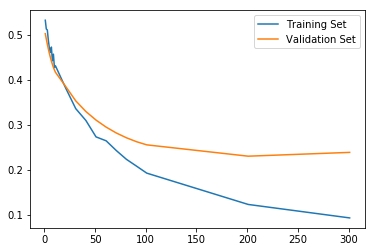

In [3]:
print "\n 8. Loss Function"
plt.plot(objlist[4],objlist[0],label="Training Set")
plt.plot(objlist[4],objlist[1],label="Validation Set")
plt.legend()
plt.show()

9. Accuracy


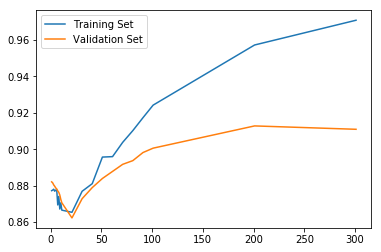

In [4]:
print "9. Accuracy"
plt.plot(objlist[4],objlist[2],label="Training Set")
plt.plot(objlist[4],objlist[3],label="Validation Set")
plt.legend()
plt.show()

In [19]:
tf.logging.set_verbosity(tf.logging.ERROR)
print "10. Final Model Evaluation on Test Set"

predictions  = np.vectorize(lambda x: 1 if x>0.5 else 0)(sess.run(predict, feed_dict={inp: matrix_test.todense(), op: target_test}))

testdf = pd.DataFrame(predictions,columns=["predictions"])
testdf["target"] = target_test
posdf = testdf[testdf["target"]==1]

true_pos = float(sum(posdf["predictions"]))
tot_pred = sum(testdf["predictions"])
all_pos = len(posdf)

prec = round(true_pos/tot_pred,2)
rec = round(true_pos/all_pos,2)
fscore = 2*((prec*rec)/(prec+rec))

print "Accuracy from TensorFlow : " + str(sess.run(accuracy, feed_dict={inp: matrix_test.todense(), op: target_test}))
print "Precision %: " + str(prec*100)
print "Recall %: " + str(rec*100) 
print "F-Score: (max is 1) " + str(fscore)


10. Final Model Evaluation on Test Set
Accuracy from TensorFlow : 0.8883333
Precision %: 61.0
Recall %: 50.0
F-Score: (max is 1) 0.54954954955
